# MIVA - Fase 2: Análise Qualitativa

**Módulo V: Análise Qualitativa de Casos Discordantes**

Este notebook complementa o experimento empírico (fase2_experimento_empirico.ipynb) com uma análise detalhada das frases que mais amplificam viés.

**PRÉ-REQUISITOS:**
- Execute primeiro o notebook `fase2_experimento_empirico.ipynb` até o final do Módulo IV
- Este notebook utiliza variáveis e arquivos gerados pelo experimento principal

## 1. Setup e Carregamento de Dados

Carrega as variáveis e resultados necessários do experimento principal.

In [1]:
# Importações
import pandas as pd
import numpy as np
from pathlib import Path
import warnings

# Scikit-learn
from sklearn.metrics import cohen_kappa_score

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações
warnings.filterwarnings('ignore')

# ============================================================================
# ESTILO ACADÊMICO NATURE (azulado)
# ============================================================================
plt.style.use('seaborn-v0_8-whitegrid')

# Paleta Nature: tons de azul acadêmico
NATURE_BLUE = '#0C4A6E'       # Azul principal escuro
NATURE_BLUE_MED = '#0284C7'   # Azul médio
NATURE_BLUE_LIGHT = '#38BDF8' # Azul claro
NATURE_GRAY = '#64748B'       # Cinza complementar
NATURE_ACCENT = '#1E3A5F'     # Azul accent

# Paleta para gráficos categóricos
NATURE_PALETTE = [NATURE_BLUE, NATURE_BLUE_MED, NATURE_BLUE_LIGHT, NATURE_GRAY]

# Paleta para modelos (Nature style)
CORES_MODELOS_NATURE = {
    'SVM': '#0C4A6E',  # Azul escuro
    'NB': '#0284C7',   # Azul médio  
    'RF': '#0EA5E9',   # Azul claro
    'LR': '#38BDF8'    # Azul mais claro
}

# Cores de intensidade (mantidas para gráficos semânticos)
COR_NEGATIVA = '#DC2626'  # Vermelho
COR_NEUTRA = '#6B7280'    # Cinza
COR_POSITIVA = '#0284C7'  # Azul

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'axes.labelsize': 12,
    'axes.labelweight': 'bold',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--'
})

sns.set_palette(NATURE_PALETTE)
pd.options.display.float_format = '{:.4f}'.format

print("✓ Bibliotecas importadas com sucesso!")
print("✓ Estilo acadêmico Nature aplicado")

✓ Bibliotecas importadas com sucesso!
✓ Estilo acadêmico Nature aplicado


In [2]:
# Configurações globais
SEED = 42
DATA_DIR = Path("data")
RESULTS_DIR = DATA_DIR / "resultados_empiricos"
GRAFICOS_DIR = RESULTS_DIR / "graficos_empiricos"

INPUT_FILE = "data/logs_processados/MQD-1209_majoritarias.csv"

# Mapeamento de classes
CLASSE_MAP = {'negativa': -1, 'neutra': 0, 'positiva': 1}
CLASSE_REVERSO = {v: k for k, v in CLASSE_MAP.items()}

# Modelos (para referência)
modelos = {
    'SVM': 'SVM',
    'NB': 'NB',
    'RF': 'RF',
    'LR': 'LR'
}

print("="*80)
print("MÓDULO V: ANÁLISE QUALITATIVA")
print("="*80)

MÓDULO V: ANÁLISE QUALITATIVA


In [3]:
# Carregar dados originais
df = pd.read_csv(INPUT_FILE, sep='\t')
y_masculino = df['classificacao_majoritaria_masculino'].map(CLASSE_MAP)
y_feminino = df['classificacao_majoritaria_feminino'].map(CLASSE_MAP)

print(f"\n✓ Dataset original carregado: {len(df)} frases")
print(f"✓ Mapeamento de classes configurado")


✓ Dataset original carregado: 1209 frases
✓ Mapeamento de classes configurado


In [4]:
# Carregar resultados do experimento principal
df_predicoes = pd.read_csv(RESULTS_DIR / "predicoes_completas.csv")

print(f"\n✓ Predições carregadas: {len(df_predicoes)} registros")
print(f"✓ Modelos: {df_predicoes['modelo'].unique().tolist()}")
print(f"✓ {df_predicoes['frase_id'].nunique()} frases únicas")


✓ Predições carregadas: 4836 registros
✓ Modelos: ['SVM', 'NB', 'RF', 'LR']
✓ 1209 frases únicas


## 2. Análise de Padrões de Classificação

Classifica as predições em padrões que revelam amplificação, preservação ou resolução de divergências.

In [5]:
# Enriquecer predições com baseline
df_predicoes_enriquecido = df_predicoes.copy()

for idx, row in df_predicoes_enriquecido.iterrows():
    frase_id = row['frase_id']
    df_predicoes_enriquecido.loc[idx, 'baseline_masculino'] = int(y_masculino.iloc[frase_id])
    df_predicoes_enriquecido.loc[idx, 'baseline_feminino'] = int(y_feminino.iloc[frase_id])

def classificar_padrao(row):
    """
    Classifica padrões considerando mudanças em relação ao baseline.
    
    Tipos:
        - PRESERVACAO: baseline concorda, modelos concordam
        - AMPLIFICACAO_BILATERAL: baseline concorda, ambos modelos mudaram e divergiram
        - AMPLIFICACAO_UNILATERAL: baseline concorda, apenas um modelo mudou
        - RESOLUCAO: baseline discorda, modelos concordam
        - PERSISTENCIA: baseline discorda, modelos discordam
    """
    concorda_baseline = (row['real_masculino'] == row['real_feminino'])
    concorda_modelos = (row['pred_masculino'] == row['pred_feminino'])
    
    masc_mudou = (row['pred_masculino'] != row['real_masculino'])
    fem_mudou = (row['pred_feminino'] != row['real_feminino'])
    
    if concorda_baseline and concorda_modelos:
        return 'PRESERVACAO'
    
    elif concorda_baseline and not concorda_modelos:
        if masc_mudou and fem_mudou:
            return 'AMPLIFICACAO_BILATERAL'
        elif masc_mudou or fem_mudou:
            return 'AMPLIFICACAO_UNILATERAL'
        else:
            return 'PRESERVACAO'
    
    elif not concorda_baseline and concorda_modelos:
        return 'RESOLUCAO'
    
    else:
        return 'PERSISTENCIA'

df_predicoes_enriquecido['padrao'] = df_predicoes_enriquecido.apply(classificar_padrao, axis=1)

print("\nDistribuição de Padrões por Modelo:\n")

analise_padroes = []
for modelo in modelos.keys():
    pred_modelo = df_predicoes_enriquecido[df_predicoes_enriquecido['modelo'] == modelo]
    
    padroes = pred_modelo['padrao'].value_counts()
    total = len(pred_modelo)
    
    analise = {
        'modelo': modelo,
        'preservacao': padroes.get('PRESERVACAO', 0),
        'preservacao_pct': (padroes.get('PRESERVACAO', 0) / total) * 100,
        'amplificacao_bilateral': padroes.get('AMPLIFICACAO_BILATERAL', 0),
        'amplificacao_bilateral_pct': (padroes.get('AMPLIFICACAO_BILATERAL', 0) / total) * 100,
        'amplificacao_unilateral': padroes.get('AMPLIFICACAO_UNILATERAL', 0),
        'amplificacao_unilateral_pct': (padroes.get('AMPLIFICACAO_UNILATERAL', 0) / total) * 100,
        'amplificacao_total': padroes.get('AMPLIFICACAO_BILATERAL', 0) + padroes.get('AMPLIFICACAO_UNILATERAL', 0),
        'amplificacao_total_pct': ((padroes.get('AMPLIFICACAO_BILATERAL', 0) + 
                                     padroes.get('AMPLIFICACAO_UNILATERAL', 0)) / total) * 100,
        'resolucao': padroes.get('RESOLUCAO', 0),
        'resolucao_pct': (padroes.get('RESOLUCAO', 0) / total) * 100,
        'persistencia': padroes.get('PERSISTENCIA', 0),
        'persistencia_pct': (padroes.get('PERSISTENCIA', 0) / total) * 100
    }
    
    analise_padroes.append(analise)
    
    print(f"  {modelo}:")
    print(f"    Preservação:        {analise['preservacao']:4d} ({analise['preservacao_pct']:5.1f}%)")
    print(f"    Amplif. Bilateral:  {analise['amplificacao_bilateral']:4d} ({analise['amplificacao_bilateral_pct']:5.1f}%) 🔴")
    print(f"    Amplif. Unilateral: {analise['amplificacao_unilateral']:4d} ({analise['amplificacao_unilateral_pct']:5.1f}%) 🟠")
    print(f"    Amplif. TOTAL:      {analise['amplificacao_total']:4d} ({analise['amplificacao_total_pct']:5.1f}%) ⚠️")
    print(f"    Resolução:          {analise['resolucao']:4d} ({analise['resolucao_pct']:5.1f}%)")
    print(f"    Persistência:       {analise['persistencia']:4d} ({analise['persistencia_pct']:5.1f}%)")
    print()

df_padroes = pd.DataFrame(analise_padroes)


Distribuição de Padrões por Modelo:

  SVM:
    Preservação:         684 ( 56.6%)
    Amplif. Bilateral:   118 (  9.8%) 🔴
    Amplif. Unilateral:  219 ( 18.1%) 🟠
    Amplif. TOTAL:       337 ( 27.9%) ⚠️
    Resolução:           119 (  9.8%)
    Persistência:         69 (  5.7%)

  NB:
    Preservação:         697 ( 57.7%)
    Amplif. Bilateral:    98 (  8.1%) 🔴
    Amplif. Unilateral:  226 ( 18.7%) 🟠
    Amplif. TOTAL:       324 ( 26.8%) ⚠️
    Resolução:           128 ( 10.6%)
    Persistência:         60 (  5.0%)

  RF:
    Preservação:         678 ( 56.1%)
    Amplif. Bilateral:   115 (  9.5%) 🔴
    Amplif. Unilateral:  228 ( 18.9%) 🟠
    Amplif. TOTAL:       343 ( 28.4%) ⚠️
    Resolução:           126 ( 10.4%)
    Persistência:         62 (  5.1%)

  LR:
    Preservação:         698 ( 57.7%)
    Amplif. Bilateral:   103 (  8.5%) 🔴
    Amplif. Unilateral:  220 ( 18.2%) 🟠
    Amplif. TOTAL:       323 ( 26.7%) ⚠️
    Resolução:           128 ( 10.6%)
    Persistência:         60 (  

## 3. Identificação de Frases Amplificadoras

Identifica e ranqueia as frases que causam maior amplificação de viés.

In [6]:
# Identificar frases amplificadoras (bilateral e unilateral)
frases_amplificacao = df_predicoes_enriquecido[
    df_predicoes_enriquecido['padrao'].isin(['AMPLIFICACAO_BILATERAL', 'AMPLIFICACAO_UNILATERAL'])
].copy()

# VERIFICAÇÃO DE SANIDADE: Todas as frases devem ter baseline concordante
print("\n[VERIFICAÇÃO] Checando integridade dos dados...")
problemas = 0
for frase_id in frases_amplificacao['frase_id'].unique():
    baseline_masc = y_masculino.iloc[frase_id]
    baseline_fem = y_feminino.iloc[frase_id]
    
    if baseline_masc != baseline_fem:
        print(f"⚠️ ERRO: Frase {frase_id} classificada como amplificação mas baseline não concorda!")
        print(f"   Baseline: M={CLASSE_REVERSO[baseline_masc]}, F={CLASSE_REVERSO[baseline_fem]}")
        problemas += 1

if problemas == 0:
    print("✓ Todas as frases amplificadoras têm baseline concordante")
else:
    print(f"❌ {problemas} frases com problema detectado!")

# Score de severidade:
# - Bilateral (ambos modelos erraram e divergiram): 2 pontos
# - Unilateral (apenas um modelo errou): 1 ponto
def calcular_score_severidade(padrao):
    if padrao == 'AMPLIFICACAO_BILATERAL':
        return 2
    else:  # AMPLIFICACAO_UNILATERAL
        return 1

frases_amplificacao['score_severidade'] = frases_amplificacao['padrao'].apply(
    calcular_score_severidade
)

# Agregar por frase - CORRIGIDO para contar separadamente bilateral e unilateral
amplificacao_por_frase = frases_amplificacao.groupby('frase_id').agg({
    'modelo': lambda x: list(x),
    'padrao': lambda x: list(x),
    'frase': 'first',
    'baseline_masculino': 'first',
    'baseline_feminino': 'first',
    'score_severidade': 'sum'
}).reset_index()

# Contar modelos que amplificam (total)
amplificacao_por_frase['n_modelos_amplificam'] = amplificacao_por_frase['modelo'].apply(len)

# Contar bilateral vs unilateral por frase
amplificacao_por_frase['n_bilateral'] = amplificacao_por_frase['padrao'].apply(
    lambda x: sum(1 for p in x if p == 'AMPLIFICACAO_BILATERAL')
)
amplificacao_por_frase['n_unilateral'] = amplificacao_por_frase['padrao'].apply(
    lambda x: sum(1 for p in x if p == 'AMPLIFICACAO_UNILATERAL')
)

# ============================================================================
# Cálculo de força da maioria dos anotadores
# ============================================================================
print("\n[NOVO] Calculando força da concordância dos anotadores...")

def calcular_forca_maioria(frase_id, grupo):
    """
    Calcula a força da maioria para uma frase.
    Retorna a proporção de votos na classe majoritária.
    Quanto maior, mais forte a concordância entre anotadores.
    """
    row = df.iloc[frase_id]
    
    if grupo == 'masculino':
        total = row['total_classificacoes_masculino']
        classe_maj = row['classificacao_majoritaria_masculino']
        votos_maj = row[f'total_{classe_maj}_masculino']
    else:
        total = row['total_classificacoes_feminino']
        classe_maj = row['classificacao_majoritaria_feminino']
        votos_maj = row[f'total_{classe_maj}_feminino']
    
    return votos_maj / total if total > 0 else 0

# Adicionar força da maioria para cada frase
amplificacao_por_frase['forca_maioria_masc'] = amplificacao_por_frase['frase_id'].apply(
    lambda x: calcular_forca_maioria(x, 'masculino')
)
amplificacao_por_frase['forca_maioria_fem'] = amplificacao_por_frase['frase_id'].apply(
    lambda x: calcular_forca_maioria(x, 'feminino')
)

# Força combinada (média das duas forças)
amplificacao_por_frase['forca_maioria_combinada'] = (
    amplificacao_por_frase['forca_maioria_masc'] + 
    amplificacao_por_frase['forca_maioria_fem']
) / 2

# ============================================================================
# RANKING: Score de severidade → Força da maioria (desempate)
# ============================================================================
amplificacao_por_frase = amplificacao_por_frase.sort_values(
    ['score_severidade', 'forca_maioria_combinada', 'n_modelos_amplificam'], 
    ascending=[False, False, False]
)

# DIAGNÓSTICO DETALHADO DO RANKING
print("\n" + "="*120)
print("DIAGNÓSTICO: Análise do Ranking (CORRIGIDO)")
print("="*120)

print(f"\nTotal de frases com amplificação: {len(amplificacao_por_frase)}")
print(f"Score máximo: {amplificacao_por_frase['score_severidade'].max()}")
print(f"Score mínimo: {amplificacao_por_frase['score_severidade'].min()}")

print("\nTOP 5 Frases - Análise Detalhada:")

for rank, (_, row) in enumerate(amplificacao_por_frase.head(5).iterrows(), 1):
    frase_id = row['frase_id']
    score = row['score_severidade']
    n_bi = row['n_bilateral']
    n_uni = row['n_unilateral']
    forca_comb = row['forca_maioria_combinada']
    
    print(f"\n{'─'*100}")
    print(f"RANK #{rank}: Frase ID {frase_id}")
    print(f"Score: {score} | Composição: {n_bi} bilateral + {n_uni} unilateral | Força Maioria: {forca_comb:.2%}")
    
    # Detalhes da força da maioria
    frase_row = df.iloc[frase_id]
    print(f"  Anotadores M: {int(frase_row['total_classificacoes_masculino'])} votos, "
          f"maioria={frase_row['classificacao_majoritaria_masculino']} "
          f"({row['forca_maioria_masc']:.0%})")
    print(f"  Anotadores F: {int(frase_row['total_classificacoes_feminino'])} votos, "
          f"maioria={frase_row['classificacao_majoritaria_feminino']} "
          f"({row['forca_maioria_fem']:.0%})")
    
    # Verificar baseline
    baseline_masc = y_masculino.iloc[frase_id]
    baseline_fem = y_feminino.iloc[frase_id]
    
    print(f"  Baseline: Masc={CLASSE_REVERSO[baseline_masc]}, Fem={CLASSE_REVERSO[baseline_fem]}", end="")
    if baseline_masc == baseline_fem:
        print(" ✓ (concordam)")
    else:
        print(" ❌ (NÃO concordam - ERRO!)")
    
    # Analisar cada modelo com verificação correta
    preds = df_predicoes_enriquecido[
        (df_predicoes_enriquecido['frase_id'] == frase_id) &
        (df_predicoes_enriquecido['padrao'].isin(['AMPLIFICACAO_BILATERAL', 'AMPLIFICACAO_UNILATERAL']))
    ]
    
    print("\n  Predições:")
    for _, p in preds.iterrows():
        tipo_icon = "🔴" if p['padrao'] == 'AMPLIFICACAO_BILATERAL' else "🟠"
        tipo_text = p['padrao'].replace('AMPLIFICACAO_', '')
        
        pred_masc = CLASSE_REVERSO[p['pred_masculino']]
        pred_fem = CLASSE_REVERSO[p['pred_feminino']]
        real_masc = CLASSE_REVERSO[p['real_masculino']]
        real_fem = CLASSE_REVERSO[p['real_feminino']]
        
        masc_mudou = (p['pred_masculino'] != p['real_masculino'])
        fem_mudou = (p['pred_feminino'] != p['real_feminino'])
        
        masc_status = "⚠️MUDOU" if masc_mudou else "✓manteve"
        fem_status = "⚠️MUDOU" if fem_mudou else "✓manteve"
        
        print(f"    {tipo_icon} {p['modelo']:5s} ({tipo_text:10s}):")
        print(f"        Masculino: {real_masc:8s} → {pred_masc:8s} [{masc_status}]")
        print(f"        Feminino:  {real_fem:8s} → {pred_fem:8s} [{fem_status}]")

print("\n" + "="*120)


[VERIFICAÇÃO] Checando integridade dos dados...
✓ Todas as frases amplificadoras têm baseline concordante

[NOVO] Calculando força da concordância dos anotadores...

DIAGNÓSTICO: Análise do Ranking (CORRIGIDO)

Total de frases com amplificação: 595
Score máximo: 8
Score mínimo: 1

TOP 5 Frases - Análise Detalhada:

────────────────────────────────────────────────────────────────────────────────────────────────────
RANK #1: Frase ID 400
Score: 8 | Composição: 4 bilateral + 0 unilateral | Força Maioria: 100.00%
  Anotadores M: 4 votos, maioria=negativa (100%)
  Anotadores F: 4 votos, maioria=negativa (100%)
  Baseline: Masc=negativa, Fem=negativa ✓ (concordam)

  Predições:
    🔴 SVM   (BILATERAL ):
        Masculino: negativa → positiva [⚠️MUDOU]
        Feminino:  negativa → neutra   [⚠️MUDOU]
    🔴 NB    (BILATERAL ):
        Masculino: negativa → positiva [⚠️MUDOU]
        Feminino:  negativa → neutra   [⚠️MUDOU]
    🔴 RF    (BILATERAL ):
        Masculino: negativa → positiva [⚠️MU

## 4. TOP 10 Frases Amplificadoras - Análise Completa

In [7]:
# ============================================================================
# TOP 10 FRASES AMPLIFICADORAS - ANÁLISE DETALHADA
# ============================================================================
print("\n" + "="*120)
print("TOP 10 FRASES AMPLIFICADORAS - ANÁLISE COMPLETA")
print("="*120)

print("\n✓ Legenda:")
print("  🔴 Score 7-8: Criticidade MÁXIMA  |  🟠 Score 5-6: Criticidade ALTA")
print("  🟡 Score 3-4: Criticidade MODERADA |  🟢 Score 1-2: Criticidade BAIXA")
print("  bi = bilateral (ambos modelos erraram) | uni = unilateral (um modelo errou)")
print("  Força = concordância média dos anotadores (desempate)")

top10_amplificadoras = amplificacao_por_frase.head(10)

for rank, (_, row) in enumerate(top10_amplificadoras.iterrows(), 1):
    frase_id = row['frase_id']
    frase_completa = df.iloc[frase_id]['frase']
    score = row['score_severidade']
    n_bi = row['n_bilateral']
    n_uni = row['n_unilateral']
    forca_comb = row['forca_maioria_combinada']
    
    if score >= 7:
        icone = "🔴"
    elif score >= 5:
        icone = "🟠"
    elif score >= 3:
        icone = "🟡"
    else:
        icone = "🟢"
    
    print(f"\n{'─'*120}")
    print(f"RANK #{rank}: {icone} Frase ID {frase_id}")
    print(f"Score: {score} | Composição: {n_bi} bilateral + {n_uni} unilateral | Força Maioria: {forca_comb:.2%}")
    print(f"\n  \"{frase_completa}\"")
    
    # Detalhes da força da maioria
    frase_row = df.iloc[frase_id]
    print(f"\n  Anotadores M: {int(frase_row['total_classificacoes_masculino'])} votos, "
          f"maioria={frase_row['classificacao_majoritaria_masculino']} "
          f"({row['forca_maioria_masc']:.0%})")
    print(f"  Anotadores F: {int(frase_row['total_classificacoes_feminino'])} votos, "
          f"maioria={frase_row['classificacao_majoritaria_feminino']} "
          f"({row['forca_maioria_fem']:.0%})")
    
    # Verificar baseline (AMBOS os grupos)
    baseline_masc = y_masculino.iloc[frase_id]
    baseline_fem = y_feminino.iloc[frase_id]
    
    print(f"  Baseline: Masc={CLASSE_REVERSO[baseline_masc]}, Fem={CLASSE_REVERSO[baseline_fem]}", end="")
    if baseline_masc == baseline_fem:
        print(" ✓ (concordam)")
    else:
        print(" ❌ (NÃO concordam - ERRO!)")
    
    # Analisar cada modelo com verificação correta
    preds = df_predicoes_enriquecido[
        (df_predicoes_enriquecido['frase_id'] == frase_id) &
        (df_predicoes_enriquecido['padrao'].isin(['AMPLIFICACAO_BILATERAL', 'AMPLIFICACAO_UNILATERAL']))
    ]
    
    print("\n  Predições:")
    for _, p in preds.iterrows():
        tipo_icon = "🔴" if p['padrao'] == 'AMPLIFICACAO_BILATERAL' else "🟠"
        tipo_text = p['padrao'].replace('AMPLIFICACAO_', '')
        
        pred_masc = CLASSE_REVERSO[p['pred_masculino']]
        pred_fem = CLASSE_REVERSO[p['pred_feminino']]
        real_masc = CLASSE_REVERSO[p['real_masculino']]
        real_fem = CLASSE_REVERSO[p['real_feminino']]
        
        masc_mudou = (p['pred_masculino'] != p['real_masculino'])
        fem_mudou = (p['pred_feminino'] != p['real_feminino'])
        
        masc_status = "⚠️MUDOU" if masc_mudou else "✓manteve"
        fem_status = "⚠️MUDOU" if fem_mudou else "✓manteve"
        
        print(f"    {tipo_icon} {p['modelo']:5s} ({tipo_text:10s}):")
        print(f"        Masculino: {real_masc:8s} → {pred_masc:8s} [{masc_status}]")
        print(f"        Feminino:  {real_fem:8s} → {pred_fem:8s} [{fem_status}]")

print(f"\n{'─'*120}")
print("\n✓ Análise TOP 10 concluída")


TOP 10 FRASES AMPLIFICADORAS - ANÁLISE COMPLETA

✓ Legenda:
  🔴 Score 7-8: Criticidade MÁXIMA  |  🟠 Score 5-6: Criticidade ALTA
  🟡 Score 3-4: Criticidade MODERADA |  🟢 Score 1-2: Criticidade BAIXA
  bi = bilateral (ambos modelos erraram) | uni = unilateral (um modelo errou)
  Força = concordância média dos anotadores (desempate)

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
RANK #1: 🔴 Frase ID 400
Score: 8 | Composição: 4 bilateral + 0 unilateral | Força Maioria: 100.00%

  "Você me prometeu, eu sei, eu me lembro, você jurou que ia ser pra sempre."

  Anotadores M: 4 votos, maioria=negativa (100%)
  Anotadores F: 4 votos, maioria=negativa (100%)
  Baseline: Masc=negativa, Fem=negativa ✓ (concordam)

  Predições:
    🔴 SVM   (BILATERAL ):
        Masculino: negativa → positiva [⚠️MUDOU]
        Feminino:  negativa → neutra   [⚠️MUDOU]
    🔴 NB    (BILATERAL ):
        Masculino: negativa → positiva [⚠️MUDOU]
 

## 5. Exportação de Resultados

In [8]:
# Preparar DataFrame detalhado para análise
top_amplificadoras_detalhado = []

for idx, row in amplificacao_por_frase.head(20).iterrows():
    frase_id = row['frase_id']
    frase_completa = df.iloc[frase_id]['frase']
    
    classe_masc_baseline = CLASSE_REVERSO[row['baseline_masculino']]
    classe_fem_baseline = CLASSE_REVERSO[row['baseline_feminino']]
    
    preds_frase = df_predicoes_enriquecido[
        (df_predicoes_enriquecido['frase_id'] == frase_id) &
        (df_predicoes_enriquecido['padrao'].isin(['AMPLIFICACAO_BILATERAL', 'AMPLIFICACAO_UNILATERAL']))
    ]
    
    for _, pred_row in preds_frase.iterrows():
        modelo = pred_row['modelo']
        pred_masc = CLASSE_REVERSO[pred_row['pred_masculino']]
        pred_fem = CLASSE_REVERSO[pred_row['pred_feminino']]
        
        top_amplificadoras_detalhado.append({
            'frase_id': frase_id,
            'frase': frase_completa,
            'n_modelos_total': row['n_modelos_amplificam'],
            'modelo': modelo,
            'baseline_masculino': classe_masc_baseline,
            'baseline_feminino': classe_fem_baseline,
            'pred_masculino': pred_masc,
            'pred_feminino': pred_fem
        })

df_frases_detalhado = pd.DataFrame(top_amplificadoras_detalhado)

# Salvar análises
df_predicoes_enriquecido.to_csv(RESULTS_DIR / "predicoes_com_padroes.csv", index=False)
amplificacao_por_frase.to_csv(RESULTS_DIR / "frases_amplificadoras.csv", index=False)
df_padroes.to_csv(RESULTS_DIR / "estatisticas_padroes.csv", index=False)
df_frases_detalhado.to_csv(RESULTS_DIR / "frases_amplificadoras_completo.csv", index=False)

print("\n✓ Análises qualitativas salvas:")
print("  • predicoes_com_padroes.csv")
print("  • frases_amplificadoras.csv")
print("  • estatisticas_padroes.csv")
print("  • frases_amplificadoras_completo.csv")


✓ Análises qualitativas salvas:
  • predicoes_com_padroes.csv
  • frases_amplificadoras.csv
  • estatisticas_padroes.csv
  • frases_amplificadoras_completo.csv


## 6. Visualizações

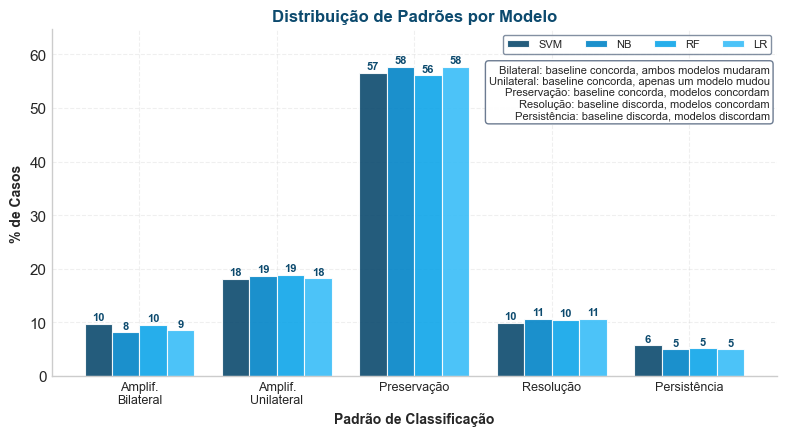

✓ Gráfico 1 salvo: grafico1_padroes_por_modelo.png


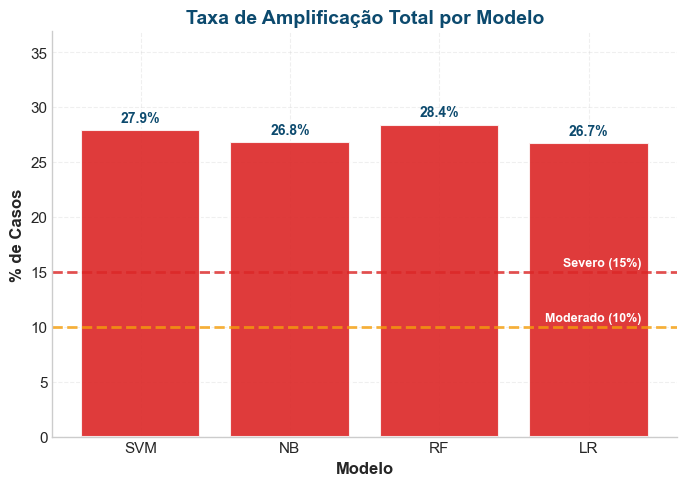

✓ Gráfico 2 salvo: grafico2_taxa_amplificacao_total.png


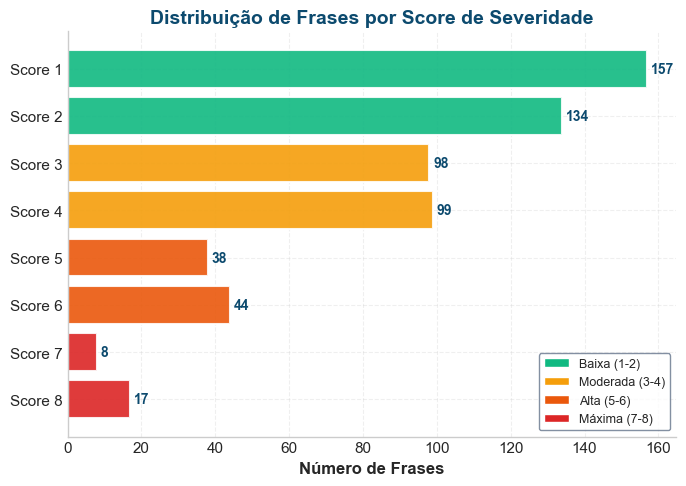

✓ Gráfico 3 salvo: grafico3_distribuicao_score_severidade.png


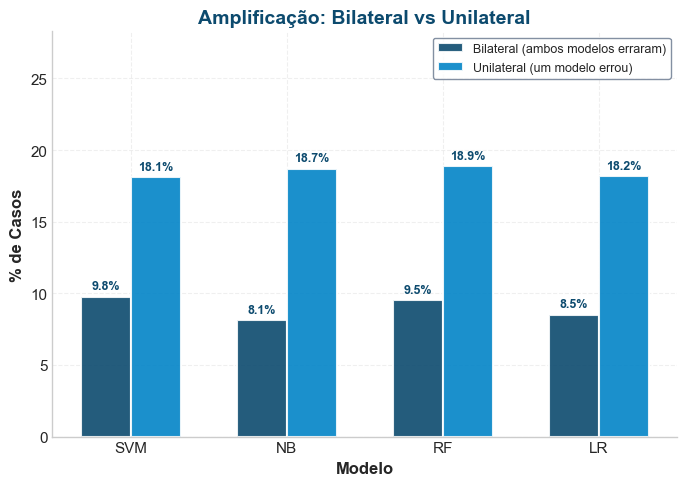

✓ Gráfico 4 salvo: grafico4_bilateral_vs_unilateral.png

✓ Todos os gráficos salvos individualmente em:
  data\resultados_empiricos\graficos_empiricos/


In [9]:
# ============================================================================
# GRÁFICO 1: Padrões por Modelo
# ============================================================================
fig1, ax1 = plt.subplots(figsize=(8, 4.5))  # Padrão acadêmico LaTeX

padroes_labels = ['Amplif.\nBilateral', 'Amplif.\nUnilateral', 'Preservação', 'Resolução', 'Persistência']
x_padroes = np.arange(len(padroes_labels))
width = 0.2  # Barras mais estreitas

for i, (_, row) in enumerate(df_padroes.iterrows()):
    modelo = row['modelo']
    valores = [
        row['amplificacao_bilateral_pct'],
        row['amplificacao_unilateral_pct'],
        row['preservacao_pct'],
        row['resolucao_pct'],
        row['persistencia_pct']
    ]
    offset = (i - 1.5) * width
    bars = ax1.bar(x_padroes + offset, valores, width, label=modelo, 
                   color=CORES_MODELOS_NATURE[modelo], alpha=0.9, 
                   edgecolor='white', linewidth=0.8)
    
    # Adicionar valores nas barras (apenas se > 2%)
    for bar, v in zip(bars, valores):
        if v > 2:
            ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.3,
                    f'{v:.0f}', ha='center', va='bottom', fontsize=8, fontweight='bold',
                    color=NATURE_BLUE)

ax1.set_xticks(x_padroes)
ax1.set_xticklabels(padroes_labels, fontsize=9)
ax1.set_ylabel('% de Casos', fontsize=10, fontweight='bold')
ax1.set_xlabel('Padrão de Classificação', fontsize=10, fontweight='bold')
ax1.set_title('Distribuição de Padrões por Modelo', fontsize=12, fontweight='bold', color=NATURE_BLUE)
ax1.legend(loc='upper right', fontsize=8, frameon=True, facecolor='white', 
           edgecolor=NATURE_GRAY, ncol=4)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_ylim(0, df_padroes['preservacao_pct'].max() * 1.12)

# Caixa de definições mais compacta
definicoes = (
    "Bilateral: baseline concorda, ambos modelos mudaram\n"
    "Unilateral: baseline concorda, apenas um modelo mudou\n"
    "Preservação: baseline concorda, modelos concordam\n"
    "Resolução: baseline discorda, modelos concordam\n"
    "Persistência: baseline discorda, modelos discordam"
)

ax1.text(0.99, 0.90, definicoes, transform=ax1.transAxes, fontsize=8,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                   edgecolor=NATURE_GRAY, alpha=0.95))

plt.tight_layout()
plt.savefig(GRAFICOS_DIR / 'grafico1_padroes_por_modelo.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico 1 salvo: grafico1_padroes_por_modelo.png")

# ============================================================================
# GRÁFICO 2: Taxa de Amplificação Total 
# ============================================================================
fig2, ax2 = plt.subplots(figsize=(7, 5))

# Cores de intensidade semânticas (verde=ok, laranja=atenção, vermelho=alerta)
cores_amp = ['#DC2626' if pct > 15 else '#F59E0B' if pct > 10 else '#10B981' 
             for pct in df_padroes['amplificacao_total_pct']]

bars = ax2.bar(df_padroes['modelo'], df_padroes['amplificacao_total_pct'],
               color=cores_amp, alpha=0.9, edgecolor='white', linewidth=1.5)

ax2.axhline(y=10, color='#F59E0B', linestyle='--', linewidth=2, alpha=0.8)
ax2.axhline(y=15, color='#DC2626', linestyle='--', linewidth=2, alpha=0.8)

# Labels nas linhas tracejadas
ax2.text(len(df_padroes)-0.65, 10.5, 'Moderado (10%)', 
         fontsize=9, color='#ffffff', fontweight='bold', ha='right')
ax2.text(len(df_padroes)-0.65, 15.5, 'Severo (15%)', 
         fontsize=9, color='#ffffff', fontweight='bold', ha='right')

ax2.set_ylabel('% de Casos', fontsize=12, fontweight='bold')
ax2.set_xlabel('Modelo', fontsize=12, fontweight='bold')
ax2.set_title('Taxa de Amplificação Total por Modelo', fontsize=14, fontweight='bold', color=NATURE_BLUE)
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_ylim(0, max(df_padroes['amplificacao_total_pct'].max() * 1.3, 20))

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{height:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=10,
            color=NATURE_BLUE)

plt.tight_layout()
plt.savefig(GRAFICOS_DIR / 'grafico2_taxa_amplificacao_total.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico 2 salvo: grafico2_taxa_amplificacao_total.png")

# ============================================================================
# GRÁFICO 3: Distribuição de Frases por Score de Severidade
# ============================================================================
fig3, ax3 = plt.subplots(figsize=(7, 5))

if len(amplificacao_por_frase) > 0:
    # Contar frases por score
    score_counts = amplificacao_por_frase['score_severidade'].value_counts().sort_index(ascending=False)
    
    # Cores semânticas de intensidade (vermelho=crítico, laranja, amarelo, verde=ok)
    cores_score = []
    for score in score_counts.index:
        if score >= 7:
            cores_score.append('#DC2626')  # Vermelho - MÁXIMA
        elif score >= 5:
            cores_score.append('#EA580C')  # Laranja - ALTA
        elif score >= 3:
            cores_score.append('#F59E0B')  # Amarelo - MODERADA
        else:
            cores_score.append('#10B981')  # Verde - BAIXA
    
    bars = ax3.barh(
        [f'Score {int(s)}' for s in score_counts.index], 
        score_counts.values,
        color=cores_score, 
        alpha=0.9, 
        edgecolor='white',
        linewidth=1.5
    )
    
    ax3.set_xlabel('Número de Frases', fontsize=12, fontweight='bold')
    ax3.set_title('Distribuição de Frases por Score de Severidade', fontsize=14, fontweight='bold', color=NATURE_BLUE)
    ax3.grid(axis='x', alpha=0.3, linestyle='--')
    
    for bar, count in zip(bars, score_counts.values):
        ax3.text(count + 1, bar.get_y() + bar.get_height()/2.,
                f'{int(count)}', ha='left', va='center', fontweight='bold', fontsize=10,
                color=NATURE_BLUE)
    
    # Adicionar legenda de severidade
    from matplotlib.patches import Patch
    legend_elements = [
        
        Patch(facecolor='#10B981', edgecolor='white', label='Baixa (1-2)'),
        Patch(facecolor='#F59E0B', edgecolor='white', label='Moderada (3-4)'),
        Patch(facecolor='#EA580C', edgecolor='white', label='Alta (5-6)'),
        Patch(facecolor='#DC2626', edgecolor='white', label='Máxima (7-8)')
    ]
    ax3.legend(handles=legend_elements, loc='lower right', fontsize=9, 
               frameon=True, facecolor='white', edgecolor=NATURE_GRAY)
else:
    ax3.text(0.5, 0.5, 'Nenhuma amplificação detectada', 
            ha='center', va='center', transform=ax3.transAxes)

plt.tight_layout()
plt.savefig(GRAFICOS_DIR / 'grafico3_distribuicao_score_severidade.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico 3 salvo: grafico3_distribuicao_score_severidade.png")

# ============================================================================
# GRÁFICO 4: Bilateral vs Unilateral
# ============================================================================
fig4, ax4 = plt.subplots(figsize=(7, 5))

x = np.arange(len(modelos))
width = 0.32

bars1 = ax4.bar(x - width/2, df_padroes['amplificacao_bilateral_pct'], width,
                label='Bilateral (ambos modelos erraram)', color=NATURE_BLUE, alpha=0.9, 
                edgecolor='white', linewidth=1.5)
bars2 = ax4.bar(x + width/2, df_padroes['amplificacao_unilateral_pct'], width,
                label='Unilateral (um modelo errou)', color=NATURE_BLUE_MED, alpha=0.9,
                edgecolor='white', linewidth=1.5)

ax4.set_ylabel('% de Casos', fontsize=12, fontweight='bold')
ax4.set_xlabel('Modelo', fontsize=12, fontweight='bold')
ax4.set_title('Amplificação: Bilateral vs Unilateral', fontsize=14, fontweight='bold', color=NATURE_BLUE)
ax4.set_xticks(x)
ax4.set_xticklabels(df_padroes['modelo'], fontsize=11)
ax4.legend(loc='upper right', fontsize=9, frameon=True, facecolor='white', edgecolor=NATURE_GRAY)
# Definir ylim com margem para legenda
max_val = max(df_padroes['amplificacao_bilateral_pct'].max(), 
              df_padroes['amplificacao_unilateral_pct'].max())
ax4.set_ylim(0, max_val * 1.5)  # 50% de margem para legenda
ax4.grid(axis='y', alpha=0.3, linestyle='--')

# Adicionar valores nas barras
for bar in bars1:
    height = bar.get_height()
    if height > 0:
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.3,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9, 
                fontweight='bold', color=NATURE_BLUE)

for bar in bars2:
    height = bar.get_height()
    if height > 0:
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.3,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9, 
                fontweight='bold', color=NATURE_BLUE)

plt.tight_layout()
plt.savefig(GRAFICOS_DIR / 'grafico4_bilateral_vs_unilateral.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico 4 salvo: grafico4_bilateral_vs_unilateral.png")

print("\n" + "="*60)
print("✓ Todos os gráficos salvos individualmente em:")
print(f"  {GRAFICOS_DIR}/")
print("="*60)

## 7. Resumo Final

In [10]:
print("="*80)
print("RESUMO - MÓDULO V: ANÁLISE QUALITATIVA")
print("="*80)

print(f"\n📊 Total de frases amplificadoras: {len(amplificacao_por_frase)}")
print(f"📊 Score máximo: {amplificacao_por_frase['score_severidade'].max()}")
print(f"📊 Score mínimo: {amplificacao_por_frase['score_severidade'].min()}")

print("\n📁 Arquivos gerados:")
for csv_file in ['predicoes_com_padroes.csv', 'frases_amplificadoras.csv', 
                 'estatisticas_padroes.csv', 'frases_amplificadoras_completo.csv']:
    print(f"  • {csv_file}")

print("\n📈 Gráficos gerados:")
for i in range(1, 5):
    print(f"  • grafico{i}_*.png")

print("\n" + "="*80)
print("✓ ANÁLISE QUALITATIVA CONCLUÍDA")
print("="*80)

RESUMO - MÓDULO V: ANÁLISE QUALITATIVA

📊 Total de frases amplificadoras: 595
📊 Score máximo: 8
📊 Score mínimo: 1

📁 Arquivos gerados:
  • predicoes_com_padroes.csv
  • frases_amplificadoras.csv
  • estatisticas_padroes.csv
  • frases_amplificadoras_completo.csv

📈 Gráficos gerados:
  • grafico1_*.png
  • grafico2_*.png
  • grafico3_*.png
  • grafico4_*.png

✓ ANÁLISE QUALITATIVA CONCLUÍDA
